# Reduction Example
### Images of NGC1341 from TOROS GW170104 response
This notebook provides an exmaple ofthe process of image reduction using images taken of the galaxy NGC1341 by the EABA 1.54-m telescope on 19 November 2017.

Image reduction can be represented by the following formalism:

$$ \mathcal{O}^\prime(x, y, t_o) = \frac{\mathcal{O}(x, y, t_o) - \langle \mathcal{D}(x, y, t_o) \rangle}{\langle \mathcal{F}(x, y, t_f) \rangle - \langle \mathcal{D}(x, y, t_f) \rangle}$$

where each term represents a total intensity of a single pixel at location $(x, y)$ and integration time $t$. The $\mathcal{O}$ term is the intensity of a pixel on the uncalibrated object frame at position $(x, y)$ at integration time $t_o$. The $\langle\mathcal{D}\rangle$ term in the numerator is a pixel on a median-combined set of dark frames, which is subtracted from the uncalibrated object frame. The $\langle\mathcal{F}\rangle$ term is a pixel on a median-combined set of flat frames. From this is subtracted another set of median-combined dark frames at an integration time matching the flat frame, rather than the object frame. The resulting difference is gives the pixel value of a calibrated frame $\mathcal{O}^\prime$.

### Load modules
This part is crucial since there are many dependencies for the example to work. Seek help from me if you cannot get these to work.

In [52]:
from astropy import units as u
from astropy.io import fits
import aplpy
import ccdproc
import glob
import numpy as np
import os

### Define location of all frame directories
There are four locations we need to keep track of in this example. There are two sets of dark frames (because we need one set to be applied to the flat frames and another to be applied to the object frames). There is a set of flat frames and also the set of uncalibrated object frames.

In [4]:
dark_flat_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/dark/flat"
dark_object_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/dark/object"
flat_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/flat"
object_dir = "/home/rcamuccio/Documents/pipeline-tutorials/data/reduction/ngc1341"

### Read dark frames (for flat correction)

INFO: Auto-setting vmin to  1.217e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.453e+03 [aplpy.core]


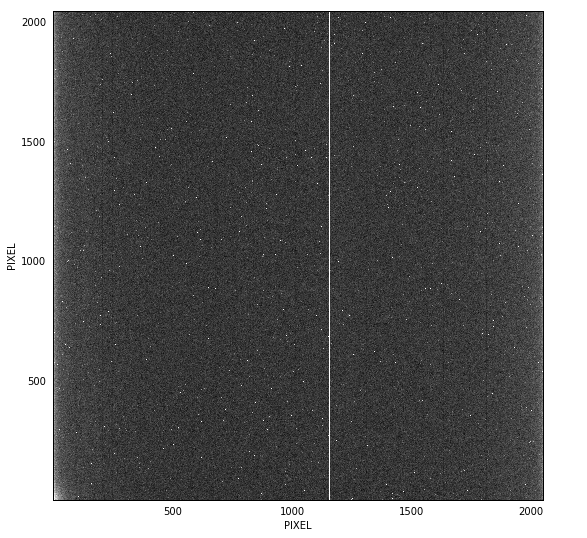

In [41]:
dark_flat_list = []
os.chdir(dark_flat_dir)

for frame in glob.glob("*.fit"):
    dark_flat_list.append(frame)
    
hdu = fits.open(frame)
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Combine dark frames (for flat correction)
Note that the constant features (hot pixels, dead pixel arrays) remain, but the background becomes darker. We're seeing the effects of 'averaging' out randomness, but non-random noise remains as a systematic defect (which is what we're going to remove via this whole reduction process).

This step gives us the $\langle\mathcal{D}(x, y, t_f)\rangle$ term.

INFO: Auto-setting vmin to  1.236e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.458e+03 [aplpy.core]


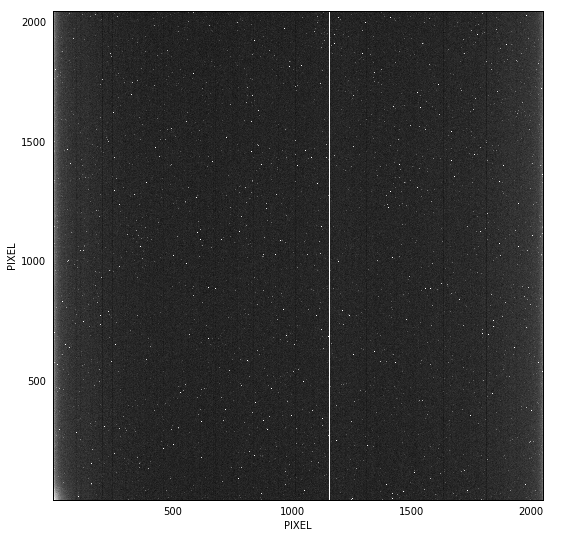

In [42]:
master_dark_for_flat = ccdproc.combine(dark_flat_list, method="median", unit="adu")

hdu = master_dark_for_flat.to_hdu()
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Read dark frames (for object correction)
You should see that these darks look different. They have different hot pixels and dead arrays than the previous set of darks.

INFO: Auto-setting vmin to  1.220e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.398e+03 [aplpy.core]


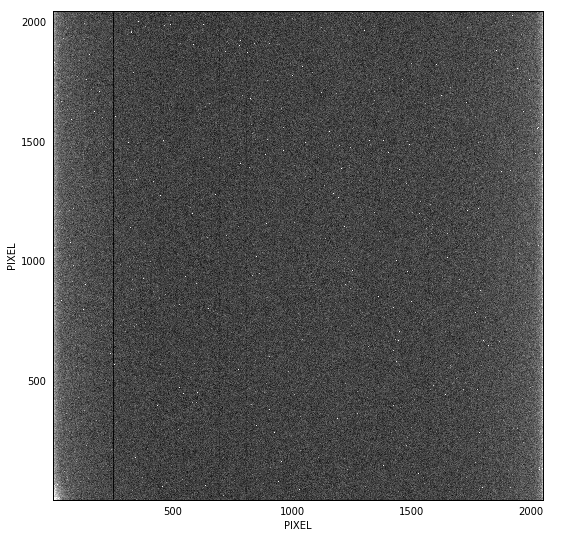

In [44]:
dark_object_list = []
os.chdir(dark_object_dir)

for frame in glob.glob("*.fit"):
    dark_object_list.append(frame)
    
hdu = fits.open(frame)
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Combine dark frames (for object correction)
This step gives us the $\langle\mathcal{D}(x, y, t_o)\rangle$ term.

INFO: Auto-setting vmin to  1.235e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.396e+03 [aplpy.core]


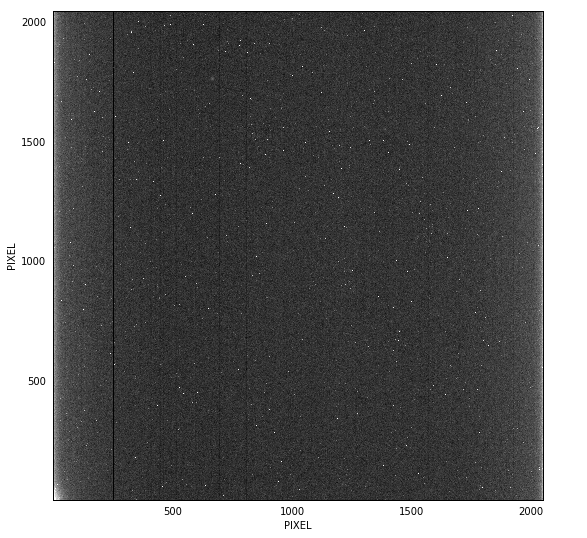

In [46]:
master_dark_for_object = ccdproc.combine(dark_object_list, method="median", unit="adu")

hdu = master_dark_for_object.to_hdu()
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Read flat frames
Flat frames represent the state of your blank canvas. It reveals all the systematic defects in your optical path, from the aperture of the telescope to the CCD sensor and everything in between. In the following flat, you'll see "donuts" (caused by dust), dead pixels, nonlinear deviation along the fringes (caused by voltage bias, chip defects, or vignetting), and hot pixels. Division of the object frame by this canvas will (in principle) undo all of these deviations.

INFO: Auto-setting vmin to  2.623e+04 [aplpy.core]
INFO: Auto-setting vmax to  2.993e+04 [aplpy.core]


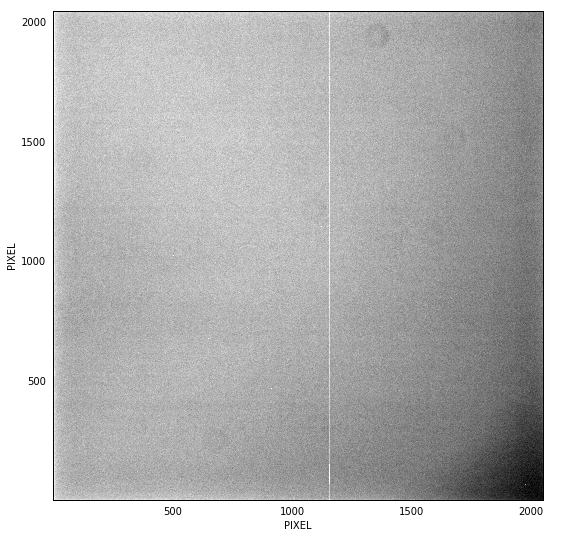

In [47]:
flat_list = []
os.chdir(flat_dir)

for frame in glob.glob("*.fit"):
    flat_list.append(frame)
    
hdu = fits.open(frame)
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Combine flat frames
This step produces the $\langle\mathcal{F}(x, y, t_f)\rangle$ term.

INFO: Auto-setting vmin to  2.629e+04 [aplpy.core]
INFO: Auto-setting vmax to  2.992e+04 [aplpy.core]


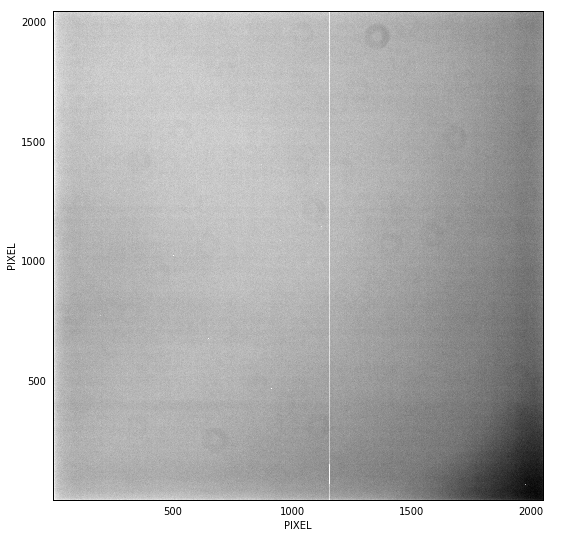

In [48]:
combined_flat = ccdproc.combine(flat_list, method="median", unit="adu")

hdu = combined_flat.to_hdu()
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Create master flat by subtracting combined dark frame
We are now doing the calculation $\langle\mathcal{F}(x, y, t_f)\rangle - \langle\mathcal{D}(x, y, t_f)\rangle$.

INFO: Auto-setting vmin to  2.603e+04 [aplpy.core]
INFO: Auto-setting vmax to  2.964e+04 [aplpy.core]


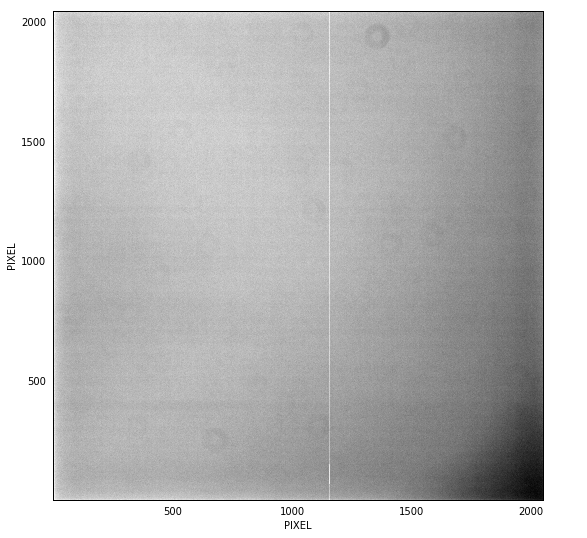

In [49]:
master_flat = ccdproc.subtract_dark(combined_flat, master_dark_for_flat, data_exposure=combined_flat.header["exposure"]*u.second, dark_exposure=master_dark_for_flat.header["exposure"]*u.second, scale=True)

hdu = master_flat.to_hdu()
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Read object frames
Finally, we can see an example of raw data of NGC1341 in unfiltered optical light. In the frame are several astronomical sources, including the target in the center of the frame and other stars. Along with these sources are image artifacts: dead pixels, hot pixels, and all of those other deviations we saw earlier. Let's remove them, since their presence affects our scientific results.

Each pixel on this frame is an example of the term $\mathcal{O}(x, y, t_o)$.

INFO: Auto-setting vmin to  1.370e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.633e+03 [aplpy.core]


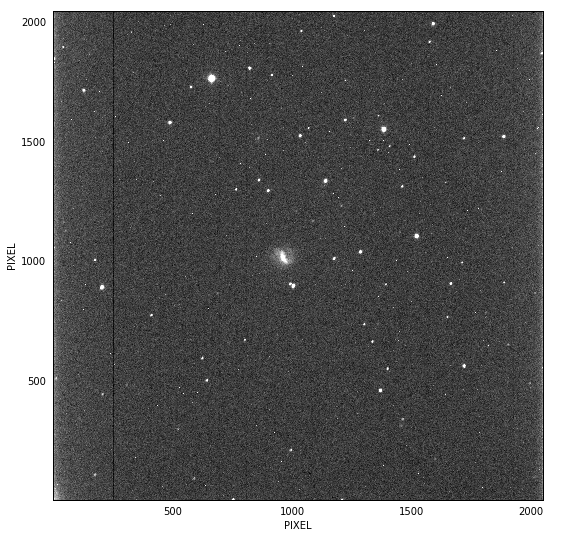

In [50]:
object_list = []
os.chdir(object_dir)
#save_directory = "/home/rcamuccio/Documents"

for frame in glob.glob("*.fit"):
    object_list.append(frame)
    
hdu = fits.open(frame)
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()

### Reduce object frames to calibrated frames

The background should look much smoother. The dead pixels have been corrected, and the hot pixels have been removed. Cosmic arrays and other transient artifacts might remain, but there are other methods to remove them. Now you can begin to take scientific measurements such as conducting photometry.

Each pixel on this frame is represented by the term $\mathcal{O}^\prime(x, y, t_o)$.

INFO: Auto-setting vmin to  1.030e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.992e+02 [aplpy.core]


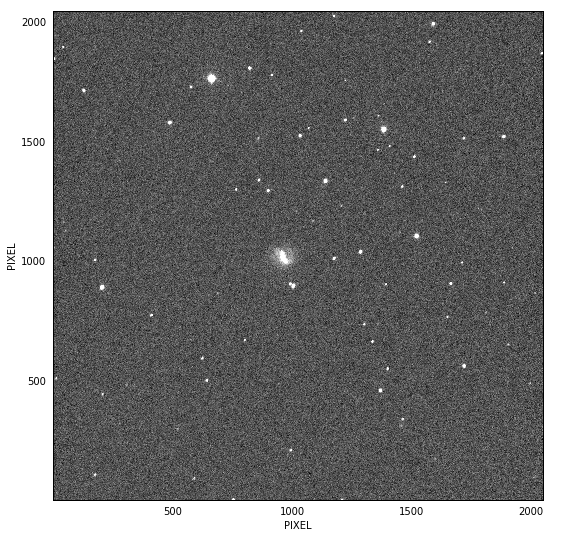

In [51]:
for frame in object_list:
    object_frame = ccdproc.fits_ccddata_reader(frame, unit="adu")
    object_min_dark = ccdproc.subtract_dark(object_frame, master_dark_for_object, data_exposure=object_frame.header["exposure"]*u.second, dark_exposure=master_dark_for_object.header["exposure"]*u.second, scale=True)
    cal_object_frame = ccdproc.flat_correct(object_min_dark, master_flat)
    #ccdproc.fits_ccddata_writer(cal_object_frame, str(save_directory) + "/cal-" + str(frame))
    
hdu = cal_object_frame.to_hdu()
frame_data = hdu[0].data
fig = aplpy.FITSFigure(frame_data)
fig.show_grayscale()